# Kaggle Leaf Classification Challenge


In [2]:
## Install pandas if you don't already have it (uncomment line below)

! pip install pandas matplotlib scikit-image scikit-learn

In [3]:
## If you are working on Colab, data_utils can be downloaded using the command below (uncomment line below)
# ! curl -O https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/6_Mini_Project/data_utils.py

In [4]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

#import sys
#sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
#                                         # libraries, like utils.py

# Tying everything together

Now that you have learned about the most common network architectures, it is time to combine them into a more advanced model. 
It often happens that you have a combination of data that cannot easily be modeled by any single one of these types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

In this notebook, we will work on the **Kaggle Leaf Classification Challenge**, a data science competition from [`kaggle.com`](https://www.kaggle.com/) that contains several different kinds of data.
We will download the data, visualize it, and train a classifier.
A simple network with poor performance is provided for you as a starting point, but it is up to you use what you have learnt to improve the results.


## Kaggle challenge

Kaggle is a website to participate in real-world challenges.
Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle public datasets [here](https://www.kaggle.com/datasets).

We will undertake the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge. We report here the description of the dataset:

> The dataset consists of approximately 1,584 images of leaf specimens which have been converted to binary black leaves against white backgrounds. 
Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.


# Get set up

**NB**: You will need a Kaggle account for this exercise!

1. Go to [Kaggle](https://www.kaggle.com/), create an account
2. [Download the dataset](https://www.kaggle.com/c/leaf-classification/data)
3. Unpack the dataset in the current directory. Structure should be as follows:
```
02456-deep-learning-with-PyTorch\4_Mini_Project
--> sample_submission.csv
--> test.csv
--> train.csv
--> images
--> --> 1.jpg
--> --> 2.jpg
--> --> 3.jpg
--> --> ...
```

# Upload data to colab
If you're running this notebook on google colab, you'll need to upload `data_utils.py` that we provide as well as the data you've just downloaded from kaggle to colab. Small files like `data_utils.py` you can simply upload via the folder icon to the left. Files that are uploaded like this, however, will be deleted every time the session ends. For big files like the kaggle data folder it's therefore better to:

1. upload the data to google drive
2. mount the google drive (see cell below)

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

After going through a quick authorization process you should now have access to the uploaded file via colab. We can check the location of our data as follows:

In [6]:
#!ls drive/'My Drive'

Let's save the path for later use. Just replace this with your local path if you're not running on colab.

In [7]:
# Since I am running locally I will use the data from the folder i am in


# Visualizing the data

First we start out by looking at the images. 
You need to load them first!
Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/).
Pandas is useful for data analysis, but we don't suggest using it in any production code.

In [8]:
image_paths = glob.glob('images/*.jpg')
print("Total Observations:\t", len(image_paths))

# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]

# now loading the test.csv
test = pd.read_csv('test.csv')

Total Observations:	 1584


## Exercise 1

1.1) How many samples do we have for training and test? Do we have the same information for training and test data? How many samples do we have for each species?

**Hint**: You might want to use .shape, .columns, pd.unique() and .symmetric_difference().


In [9]:
# Getting the number of samples for training and testing
num_train_samples = train.shape[0]
num_test_samples = test.shape[0]

print(f"Number of training samples: {num_train_samples}")
print(f"Number of test samples: {num_test_samples}")


Number of training samples: 990
Number of test samples: 594


We have 990 samples of leaves for the training set and 594 for the test set. For each sample there is a number of features. 


In the following I will look at the supplied features:

In [10]:
# Displaying the names of the features
print("Features in the dataset:")
print(list(train.columns))


Features in the dataset:
['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6', 'margin7', 'margin8', 'margin9', 'margin10', 'margin11', 'margin12', 'margin13', 'margin14', 'margin15', 'margin16', 'margin17', 'margin18', 'margin19', 'margin20', 'margin21', 'margin22', 'margin23', 'margin24', 'margin25', 'margin26', 'margin27', 'margin28', 'margin29', 'margin30', 'margin31', 'margin32', 'margin33', 'margin34', 'margin35', 'margin36', 'margin37', 'margin38', 'margin39', 'margin40', 'margin41', 'margin42', 'margin43', 'margin44', 'margin45', 'margin46', 'margin47', 'margin48', 'margin49', 'margin50', 'margin51', 'margin52', 'margin53', 'margin54', 'margin55', 'margin56', 'margin57', 'margin58', 'margin59', 'margin60', 'margin61', 'margin62', 'margin63', 'margin64', 'shape1', 'shape2', 'shape3', 'shape4', 'shape5', 'shape6', 'shape7', 'shape8', 'shape9', 'shape10', 'shape11', 'shape12', 'shape13', 'shape14', 'shape15', 'shape16', 'shape17', 'shape18', 'shape19'

This fits the data description found on the website: 

File descriptions
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format
- images - the image files (each image is named with its corresponding id)

Data fields
- id - an anonymous id unique to an image
- margin_1, margin_2, margin_3, ..., margin_64 - each of the 64 attribute vectors for the margin feature
- shape_1, shape_2, shape_3, ..., shape_64 - each of the 64 attribute vectors for the shape feature
- texture_1, texture_2, texture_3, ..., texture_64 - each of the 64 attribute vectors for the texture feature

Now I check if there are any differences in the features between training and test set:

In [11]:
# Checking if training and test data have the same columns
columns_diff = train.columns.symmetric_difference(test.columns)

if columns_diff.empty:
    print("Training and test data have the same columns.")
else:
    print(f"Columns present in one but not the other: {columns_diff}")


Columns present in one but not the other: Index(['species'], dtype='object')


It makes sense that the training data set has the extre species feature as this it the target feature we which to identify on the test dataset 

Now I will see how each species is represented in the training dataset, meaning printing how many of each species are in the dataset. To further enhance the understanding I will also do a barplot. 

Number of samples for each species in the training set:
species
Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: count, Length: 99, dtype: int64


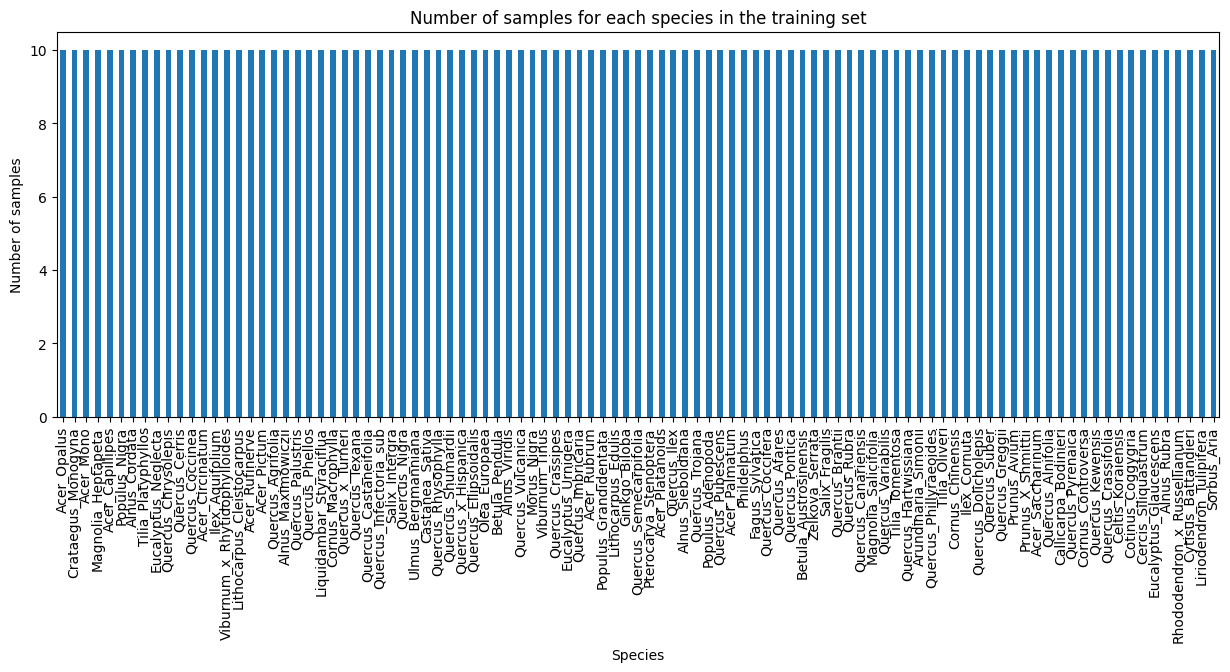

In [12]:
# Counting the number of samples for each species in the training set
species_counts = train['species'].value_counts()

print("Number of samples for each species in the training set:")
print(species_counts)

# Doing a barplot of the species counts
species_counts.plot(kind='bar', figsize=(15, 5))
plt.title("Number of samples for each species in the training set")
plt.ylabel("Number of samples")
plt.xlabel("Species")
plt.show()



I conclude that all species are equally represented in the training dataset with 10 samples each. 

With our training data and images loaded into memory.
It is time to take a look at the data.
Trying to classify leaves does not sound like a particularly difficult or interesting problem.
We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at **all** the different categories and come up with a system that discerns **all** types of leaves from each other. (In fact, distinguishing crops from weed using AI is already a thing: [weed-killing AI](https://www.cnbc.com/2018/06/04/weed-killing-ai-robot.html).)

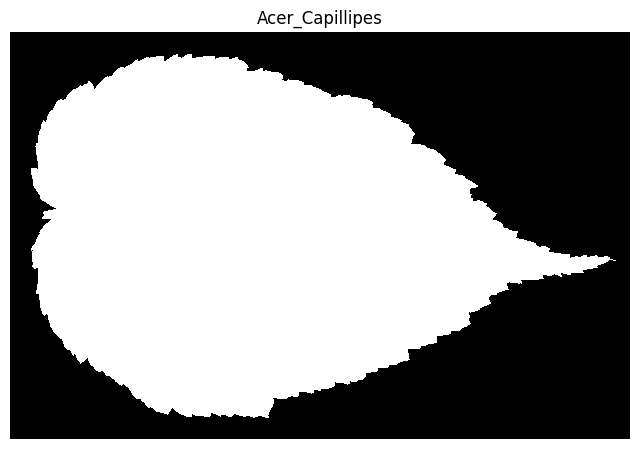

Image shape: (407, 620)


In [13]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# if on windows, replace '/' with '\\'
if os.name == 'nt':
    image_paths = [path.replace("\\", "/") for path in image_paths]


# Then we gather its index in our list of images in order to find the correct image
indexes = [image_paths.index('images/{}.jpg'.format(i)) for i in species_examples]

# Display the first image
plt.figure(figsize=(8, 8))
image = imread(image_paths[indexes[0]], as_gray=True)
plt.imshow(image, cmap='gray')
plt.title("%s" % (species[0]))
plt.axis('off')
plt.show()

# print image shape
print("Image shape:", image.shape)

## Exercise 2
2.1) In general it is a good approach to visualize an image for each category to get a better feeling of the task. You should now write some code to show 1 image from each category. You might want to use plt.subplot().

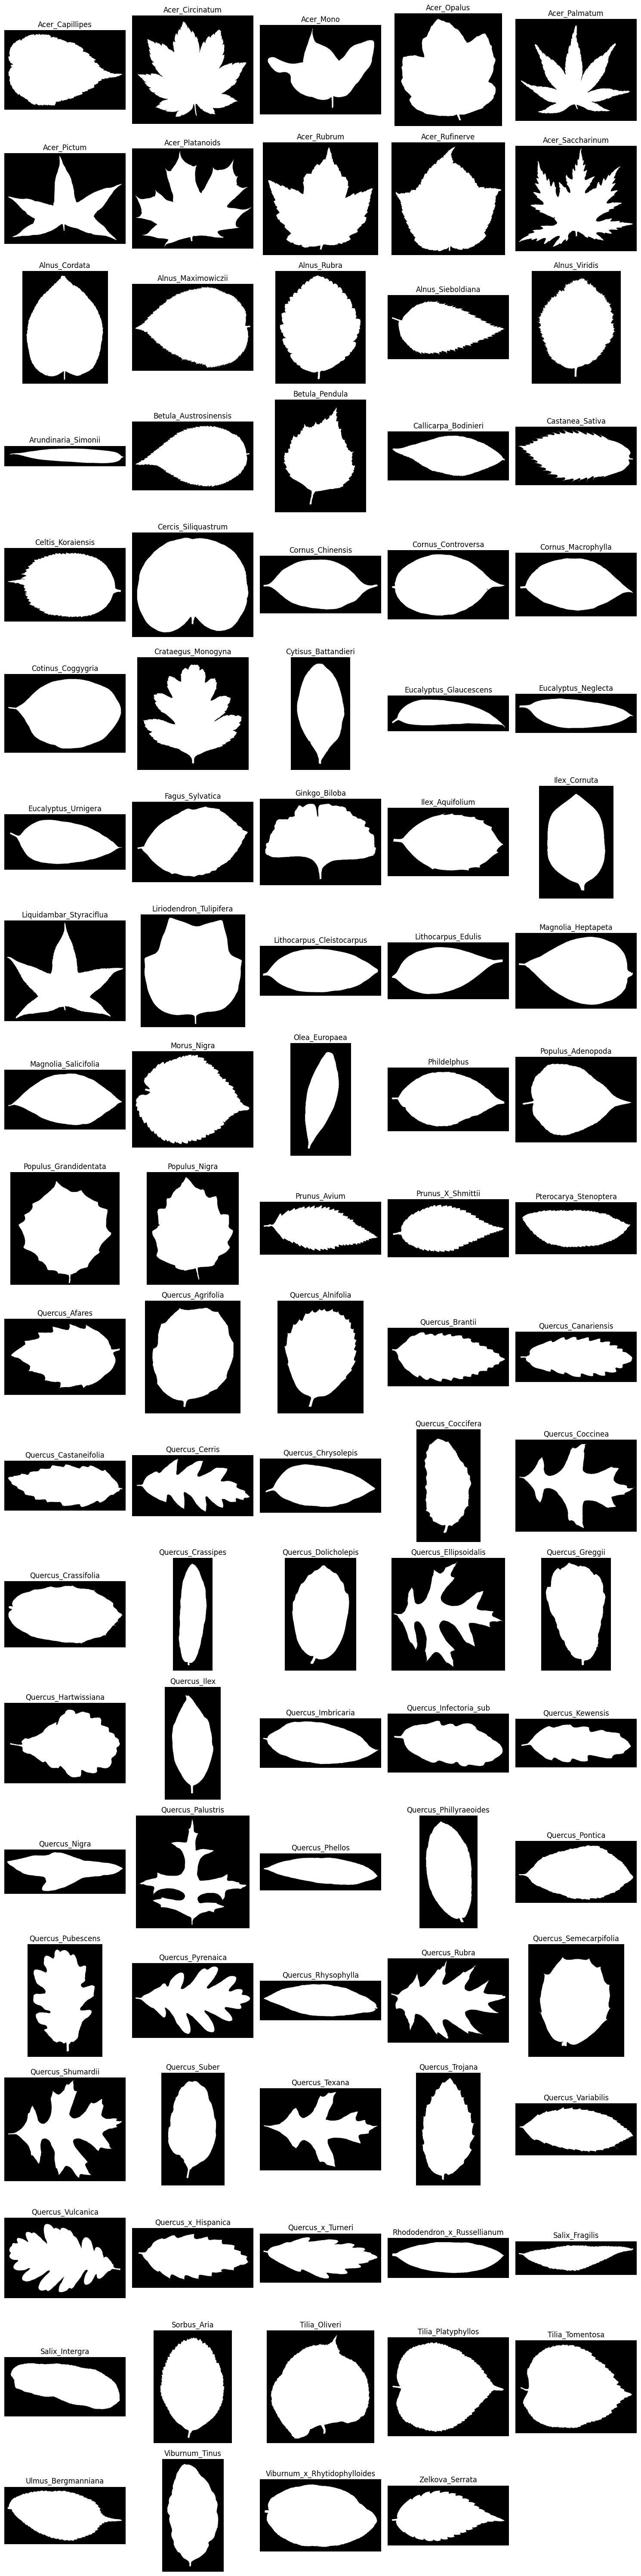

In [14]:
# Now plot 1 image from each category
# Set up the plot grid
num_species = len(species)
cols = 5  # Number of columns for the plot
rows = (num_species // cols) + 1  # Calculate required number of rows

# Create a plot
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()  # Flatten to iterate over all subplots

for i, idx in enumerate(indexes):
    # Read and plot the image
    image = imread(image_paths[idx], as_gray=True)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(species[i])
    axes[i].axis('off')  # Hide the axes for a cleaner look

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()



As you can see, classifying leaves is actually a very tough problem.
What makes it even worse is that we cannot use all the image data we have available.
In order to decrease the amount of computation needed, we need to reduce the size of the images as much as possible.
On top of that, our neural network usually only accepts fixed-size input tensors.
This means we will have to change the shape of the images so that they all have the same sizes.


Resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner.
Describing this leaf without taking its shape into account seems extremely difficult.

Therefore we will 
1. first pad all the images into squares, and
2. then resize them.

## Exercise 3

3.1) **Find an appropriate image size**. Test various resizings of the image until you have found the smallest resizing of the image where you "can still differentiate between the images".
How small is too small should ultimately be determined by an actual test, but what makes sense visually is probably a good place to start.
Change the `image_size = (?, ?)` parameter below, and note your choice.
 * **Answer:**


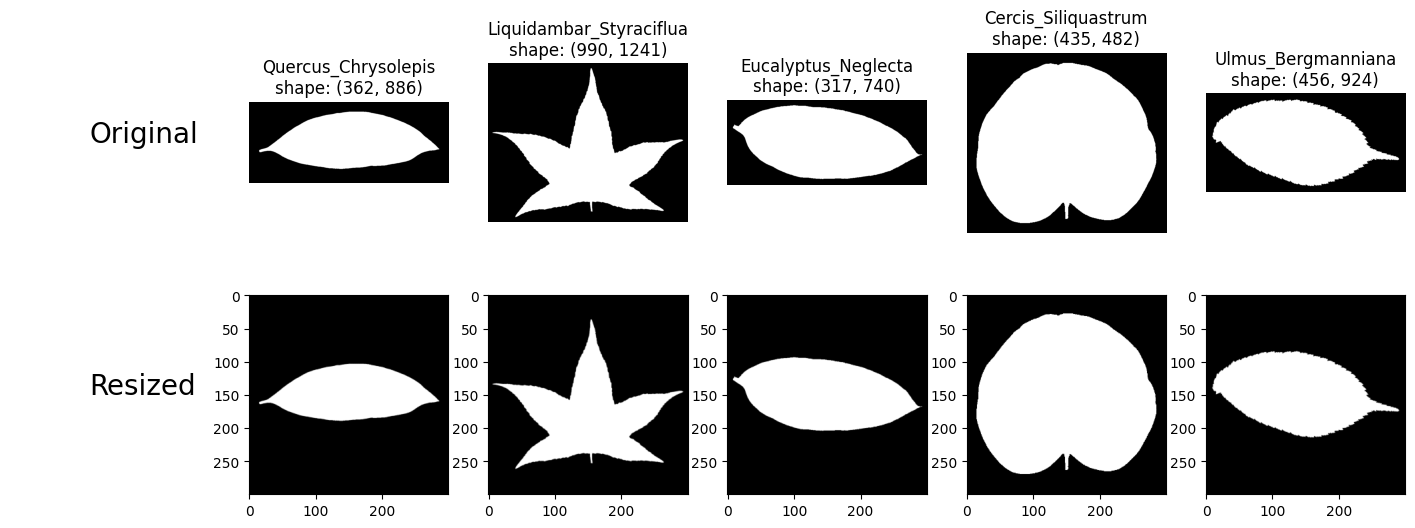

In [15]:
# Define the desired size for resizing the images (width, height)
image_size = (300, 300)  # <-- YOUR CODE HERE

# Number of images to display
amount = 5

# Randomly select 'amount' images from the list of training images
image_sample = np.random.choice(train_images, amount)

# Define the size of the entire figure (width, height in inches)
fig = plt.figure(figsize=(18, 6))

# Add a title to the first row: "Original"
ax = plt.subplot(2, amount + 1, 1)  # Create an empty subplot at position (1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)  # Add text "Original" to label the section
txt.set_clip_on(False)  # Prevent the text from being clipped by the subplot boundary
plt.axis('off')  # Hide the axes for a clean display

# Loop through the selected images to display the originals
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)  # Create a subplot for each image in the first row
    image = imread(path, as_gray=True)  # Read the image in grayscale
    plt.imshow(image, cmap='gray')  # Display the image in grayscale
    # Extract the image ID to find the corresponding species name
    _id = int(path.split('/')[-1].split('.')[0])
    # Set the title with the species name and the original image shape
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')  # Hide the axes for a clean display

# Add a title to the second row: "Resized"
ax = plt.subplot(2, amount + 1, len(image_sample) + 2)  # Create an empty subplot at the start of the second row
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)  # Add text "Resized" to label the section
txt.set_clip_on(False)  # Prevent the text from being clipped by the subplot boundary
plt.axis('off')  # Hide the axes for a clean display

# Loop through the selected images to display the resized versions
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3  # Calculate the position for each subplot in the second row
    plt.subplot(2, amount + 1, i)  # Create a subplot for each resized image
    image = imread(path, as_gray=True)  # Read the image in grayscale
    image = data_utils.pad2square(image)  # Pad the image to make it square
    # Resize the padded image to the defined 'image_size' with anti-aliasing for quality
    image = resize(image, output_shape=image_size, mode='reflect', anti_aliasing=True)
    plt.imshow(image, cmap='gray')  # Display the resized image in grayscale

# Show the figure with both the original and resized images
plt.show()

**I Choose a image sizer of 300x300 as this seems a good middelway between reducing the number of pixels and still keeping a high enough resolution to see the small edges**

## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Run it a few times to try and get an understanding of how the features differ from species to species.

In [16]:
pip install ipywidgets


Note: you may need to restart the kernel to use updated packages.


In [17]:
import ipywidgets as widgets
from IPython.display import display

In [18]:
# Extract features
X = train.values
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# Set the number of images to show at a time
amount = 20

# Create scrollable widgets for each feature category
output_widgets = []

for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    output = widgets.Output()  # Create an Output widget
    with output:
        # Set up a figure for each row
        fig, axes = plt.subplots(1, 4, figsize=(24, 2.5))
        
        # Display the species name
        ax = axes[0]
        ax.text(0.2, 0.5, species[idx][0], fontsize=15)
        ax.axis('off')
        if i == 0:
            ax.set_title('Species', fontsize=20)
        
        # Display the margin features
        ax = axes[1]
        ax.plot(margin[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Margin', fontsize=20)
        
        # Display the shape features
        ax = axes[2]
        ax.plot(shape[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Shape', fontsize=20)
        
        # Display the texture features
        ax = axes[3]
        ax.plot(texture[idx])
        ax.axis('off')
        if i == 0:
            ax.set_title('Texture', fontsize=20)
        
        # Adjust layout and display the plot
        plt.tight_layout()
        plt.show()
    
    output_widgets.append(output)

# Display all scrollable rows in a vertical box layout
scrollable_box = widgets.VBox(output_widgets, layout=widgets.Layout(max_height='600px', overflow='auto'))
display(scrollable_box)

## Exercise 4
So far we have learned about feed forward neural networks (FFNN), convolutional neural networks (CNN), recurrent neural networks (RNN), and transformers.

4.1) How could the `image`, `Margin`, `Shape` and `Texture` be used for classification, i.e. what kind of network type would you use for each of them, and why?
 

### **Answer:**

For all features (`Image`, `Margin`, `Shape`, and `Texture`), I would use a **Convolutional Neural Network (CNN)** since they all have topological information that CNNs are designed to capture effectively.

1. **Image**: CNNs are particularly suited for image data because they can capture spatial patterns like edges, textures, and shapes through their convolutional layers. These layers help identify both low-level and high-level features in the images, which is crucial for classification.

2. **Margin**: The margin of the leaf contains boundary information. CNNs are very effective at detecting such contours and edges, as their filters can learn to pick up boundary patterns that differentiate one class from another.

3. **Shape**: Shape information is inherently spatial and topological. CNNs can recognize geometric patterns and outlines effectively through their hierarchical structure, where deeper layers capture more complex patterns in the data.

4. **Texture**: Texture represents fine-grained patterns on the leaf surface. CNNs can apply filters at different scales to capture detailed texture features, making them suitable for analyzing the surface structure of leaves.

While other network types (e.g., FFNNs, RNNs) could be used, they are less appropriate since they do not leverage the spatial structure of the data effectively. CNNs are specifically designed to process topological information efficiently, making them the best choice for this classification task.


# Managing the data

The details of the code in this section isn't that important.
It simply manages the data in a nice way - so it is a good place to come back and look for inspiration when you will work on your own projects.


## Defining the data loader

## Exercise 5 
5.1) As a part of the data loader, we should specify the shape of the images, number of classes, and the number of features for the three feature types: margin, shape and texture. Define the three variables in the code below.

In [19]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (200, 300, 1)  # Height, width, 1 channel for grayscale images (adjust based on preprocessing choice)

# Define the number of classes (number of unique species in the dataset)
NUM_CLASSES = len(train['species'].unique())

# For all three feature types (margin, shape, and texture), define the number of features
# Assuming margin, shape, and texture have the same number of features as in the dataset
NUM_FEATURES = train.iloc[:, 2:66].shape[1]  # 64 features for each type (margin, shape, and texture)

# Print the defined variables for verification
print(f"IMAGE_SHAPE: {IMAGE_SHAPE}")
print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"NUM_FEATURES: {NUM_FEATURES}")


IMAGE_SHAPE: (200, 300, 1)
NUM_CLASSES: 99
NUM_FEATURES: 64


In [20]:
# Paths to data
TRAIN_PATH = "train.csv" 
TEST_PATH = "test.csv" 
IMAGE_PATHS = glob.glob("images/*.jpg")

# Check if data files has been stored with pickle as data.pickle
if not os.path.isfile("data.pickle"):
    print("Pickle file not found")
    print("Loading data from scratch")
    # train holds both X (input) and t (target/truth)
    data = data_utils.load_data(train_path=TRAIN_PATH, 
                                test_path=TEST_PATH,
                                image_paths=IMAGE_PATHS,
                                image_shape=IMAGE_SHAPE[:2])
    # to visualize the size of the dimensions of the data
    print("\n@@@Shape checking of data sets@@@")
    print("TRAIN")
    print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
    print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
    print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
    print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
    print("\tts\t %s" % (data.train['ts'].shape))
    print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
    print("TEST")
    print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
    print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
    print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
    print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
    print("\tids\t%s" % (data.test['ids'].shape))

    

#### Do you want to load your data quickly next time?
In the above cell the data is loaded, reshaped and stored as an object. If you want load this object quickly next time you should go for pickle. Pickle does effectively write an object into a character stream, so it can be loaded fastly next time. Simply replace `drive_path` with you `local_path` if you're not using colab. 

In [21]:
import pickle

# Dump the data into a pickle file in the current working directory
if not os.path.isfile("data.pickle"):
    with open('data.pickle', 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)



In [22]:
 # Load the data from a pickle file
with open('data.pickle', 'rb') as f:
    data = pickle.load(f)

## Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

### **Answer:**

The batch size is crucial for model training as it affects memory usage, training speed, and gradient estimates:

1. **Memory**: Larger batches require more memory, potentially exceeding available resources. Smaller batches are easier to fit in memory.

2. **Training Speed**: Larger batches process more samples at once, speeding up training per epoch. However, smaller batches allow more frequent parameter updates, which can benefit convergence.

3. **Gradient Estimates**: 
   - **Large Batches**: Provide more stable gradient estimates but can lead to smoother optimization paths, sometimes trapping the model in local minima.
   - **Small Batches**: Noisier gradients, which can help escape local minima but may slow convergence.

A reasonable batch size is **64**, balancing memory, speed, and gradient stability.

```python
batch_size = 64  # Chosen for balanced performance


In [23]:
batch_size = 64
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (64, 200, 300, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 200, 300, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 200, 300, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


# Build the model

In [24]:
# Load functions
! pip install torch torchvision torchaudio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [25]:
import torch

# Define Device (CUDA, MPS, CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    use_cuda = True
    print("Using GPU")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    use_cuda = True
    print("Using MPS")
else:
    device = torch.device('cpu')
    use_cuda = False
    print("Using CPU")

def get_variable(x):
    """ Converts tensors to the appropriate device (cuda, mps, or cpu). """
    if use_cuda:
        return x.to(device)
    return x

def get_numpy(x):
    """ Get numpy array for both cuda, mps, and cpu devices. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()


Using GPU


## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE

# Convolutional layer parameters
conv_out_channels = 32  # Number of filters in the convolutional layer
kernel_size = 3         # Size of the convolutional kernel
conv_stride = 1         # Stride for the convolution
conv_pad = 1            # Padding for the convolution to maintain image size

# Correctly calculate features_cat_size
features_cat_size = conv_out_channels * height * width + 128 + 32  # Conv output + margin + texture + GRU output

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layer
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        
        # Adding a recurrent unit (GRU)
        self.rnn_1 = nn.GRU(input_size=64, hidden_size=32, batch_first=True)  # Assuming input_size = 64 for the features
        
        # Output layer
        self.l_out = nn.Linear(in_features=features_cat_size,
                               out_features=NUM_CLASSES,
                               bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # Reshape input to fit the Conv2d layer
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.conv_1(x_img)                       # Apply Conv2d
        x_img = F.relu(x_img)                            # Apply activation function (ReLU)
        
        # Flatten the output for the final fully connected layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, conv_out_channels * height * width)
        features.append(features_img)
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features_vector = x
        features.append(features_vector)
        
        ## Use concatenated leaf features for RNN ##
        # Concatenate shape features into a sequence suitable for the GRU
        x_shape = x_shape.unsqueeze(1)  # Add sequence dimension for GRU (batch_size, seq_len=1, input_size=64)
        rnn_out, _ = self.rnn_1(x_shape)  # Apply GRU
        features_rnn = rnn_out[:, -1, :]   # Take the last time step output
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        
        out['out'] = self.l_out(features_final)  # Pass through the final linear layer
        return out

net = Net()
net.to(device)  # Move network to device (GPU/CPU)


Net(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (rnn_1): GRU(64, 32, batch_first=True)
  (l_out): Linear(in_features=1920160, out_features=99, bias=False)
)

# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [27]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()  # <-- Your code here.   

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

## Test network

#### Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [28]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)
output['out']

tensor([[ 0.2512,  0.0127, -0.2831,  ...,  0.3017, -0.1806, -0.0513],
        [ 0.3239,  0.3007,  0.1211,  ...,  0.0526, -0.3572,  0.1688],
        [ 0.2048,  0.1346,  0.0485,  ..., -0.4631,  0.1363,  0.3603],
        ...,
        [ 0.1614,  0.1712,  0.2495,  ...,  0.0089, -0.2585, -0.1599],
        [-0.2077,  0.5975, -0.0015,  ...,  0.0627,  0.0730,  0.2341],
        [-0.0766, -0.2228,  0.0906,  ..., -0.1043, -0.1542, -0.1394]],
       device='cuda:0', grad_fn=<MmBackward0>)

# Train

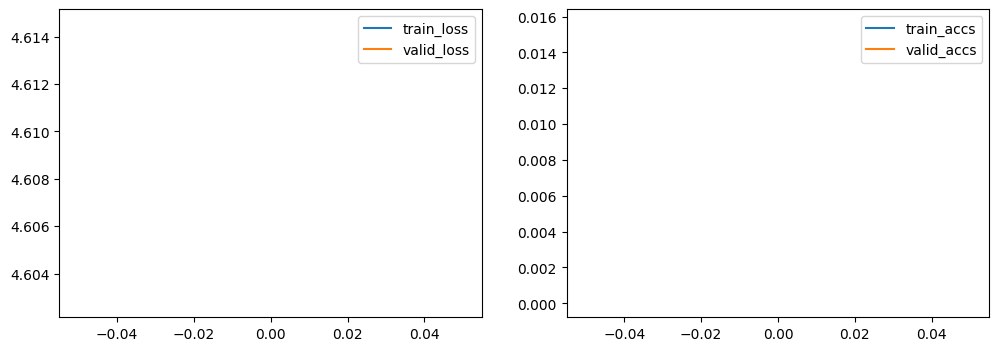

Train, it: 0 loss: 4.61 accs: 0.02


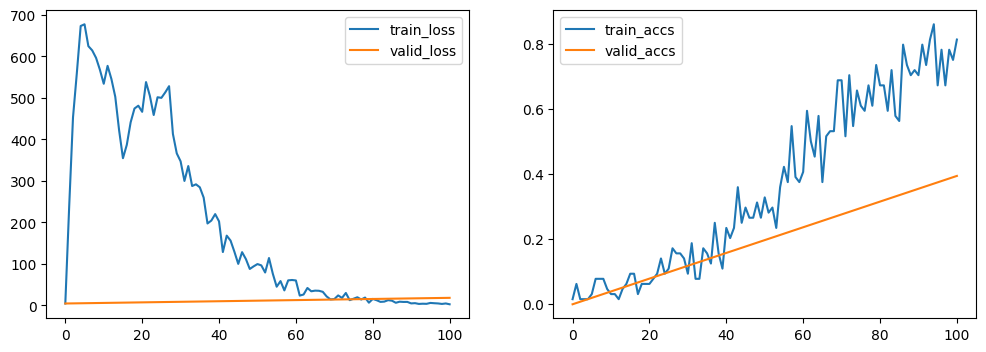

Train, it: 100 loss: 2.72 accs: 0.81


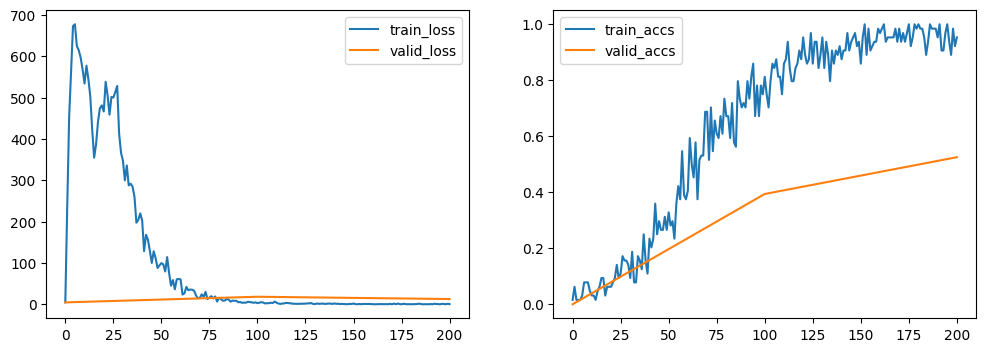

Train, it: 200 loss: 0.41 accs: 0.95


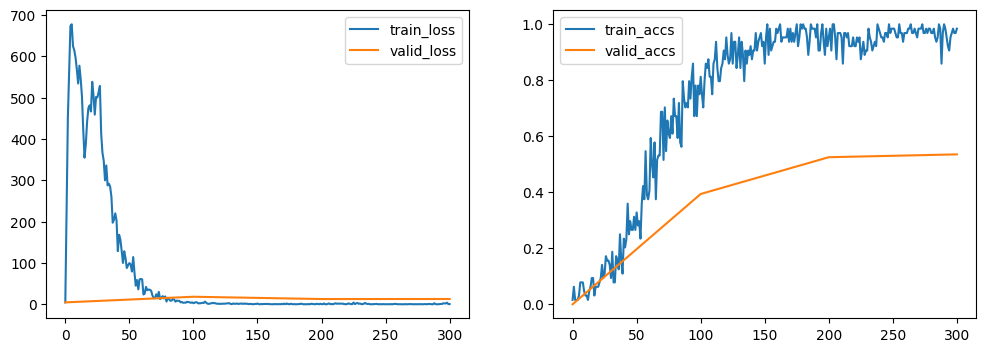

Train, it: 300 loss: 0.46 accs: 0.98


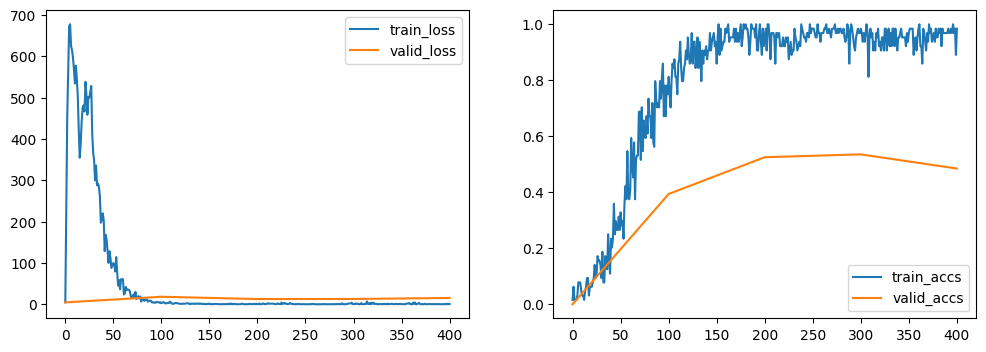

Train, it: 400 loss: 0.51 accs: 0.98


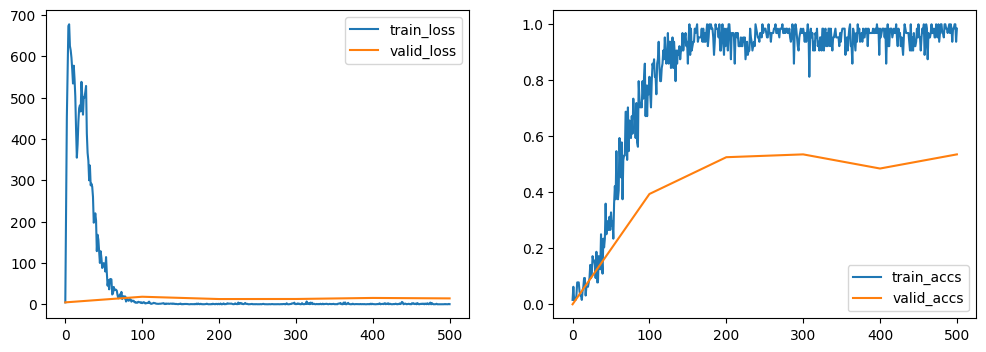

Train, it: 500 loss: 0.29 accs: 0.98


In [29]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 500
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
#         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break

This networks shows clear signs of overfitting as the training accuracy hits the 100% accuracy ceiling while the validation accuracy remains low at around 0.56. 

## Exercise 9

**Tip** This is a very small dataset (number of observations) compared to the number of features.
This means that overfitting may be an issue, and sometimes fancy tricks won't do any good. 
Keep that in mind, and always start simple.

**9.1) Improve the network**, and get as high a validation score as you can. 
When trying to improve the network nothing is sacred. You can try various learning rates, batch sizes, validation sizes, etc. 
And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you off to a good start we have created a list of **things you might want to try**:
* Add more layers (mostly fully connected and convolutional)
* Increase or decrease the batch size 
* Use dropout (a lot - e.g. between the convolutional layers)
* Use batch normalization (a lot)
* Try with L2 regularization (weight decay)
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Change the image size to be bigger or smaller
* Try other combinations of FFN, CNN, RNN parts in various ways (bigger is not always better)

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.


**9.2) Improve Kaggle score**. Once happy try to get the best score on Kaggle for this dataset as you can (**upload** instructions below)
You can upload your solution multiple times as you progress.
A very good implementation would get a score between $0.04$ to $0.06$ (the smaller the better), try and see if you can get there, and explain what might have gone wrong if you can't. 


**9.3) Reflect on the process**, and how you got to your final design and discuss your final results. 
What worked, and what didn't?
Include at least the following: 
* Description of the final architecture
* Description of the training parameters
* Description of the final results (Kaggle and validation)

**Answer:**


Before I proceed with this section I will make helper functions for training

In [30]:

def train_network(net, data, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=100, eval_every=100, validation_size=0.1):
    # Function to get label
    def get_labels(batch):
        return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

    # Function to get input
    def get_input(batch):
        return {
            'x_img': get_variable(Variable(torch.from_numpy(batch['images']).permute(0, 3, 1, 2))),  # Ensure correct shape
            'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
            'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
            'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
        }

    
    # Initialize lists for tracking training and validation metrics
    train_iter, train_loss, train_accs = [], [], []
    valid_iter, valid_loss, valid_accs = [], [], []

    # Generate batches
    batch_gen = data_utils.batch_generator(
        data,
        batch_size=batch_size,
        num_classes=NUM_CLASSES,
        num_iterations=max_iter,
        seed=42,
        val_size=validation_size
    )

    # Training loop
    net.train()
    for i, batch_train in enumerate(batch_gen.gen_train()):
        # Validation step
        print(" Step: ", i)
        if i % eval_every == 0:
            print("Evaluating")
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            for batch_valid, num in batch_gen.gen_valid():
                output = net(**get_input(batch_valid))
                labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                val_losses += criterion(output['out'], labels_argmax) * num
                val_accs += accuracy(output['out'], labels_argmax) * num
                val_lengths += num

            # Calculate averages
            val_losses /= val_lengths
            val_accs /= val_lengths
            valid_loss.append(get_numpy(val_losses))
            valid_accs.append(get_numpy(val_accs))
            valid_iter.append(i)
            net.train()
        
        # Training step
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        # Store training metrics
        train_iter.append(i)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        # Logging
        if i % log_every == 0:
            fig = plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            # Print training loss and accuracy
            print(f"Train, it: {i} loss: {train_loss[-1]:.2f} accs: {train_accs[-1]:.2f}")
            # print validation loss and accuracy
            print(f"Valid, it: {i} loss: {valid_loss[-1]:.2f} accs: {valid_accs[-1]:.2f}\n")
        
        # Early stopping condition
        if i >= max_iter:
            break

    # Return the metrics for further analysis if needed
    return {
        'train_iter': train_iter,
        'train_loss': train_loss,
        'train_accs': train_accs,
        'valid_iter': valid_iter,
        'valid_loss': valid_loss,
        'valid_accs': valid_accs
    }


In [31]:
# Also make a initialize network function
def initialize_network():
    net = Net()
    # Define Device (CUDA, MPS, CPU)
    if torch.cuda.is_available():
        device = torch.device('cuda')
        use_cuda = True
        print("Using GPU")
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
        use_cuda = True
        print("Using MPS")
    else:
        device = torch.device('cpu')
        use_cuda = False
        print("Using CPU")

    net.to(device)
    return net

In [32]:
import gc

def clear_memory():
    # Delete model, optimizer, and any large variables
    global net, optimizer, criterion, batch_gen
    del net, optimizer, criterion, batch_gen

    # Clear up Python garbage collection
    gc.collect()

    # If using GPU, clear GPU cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()



In [33]:
# Data loading and preprocessing functions
def dataloader(train_path="train.csv", test_path="test.csv", image_dir="images", pickle_file="data.pickle", image_shape=None):
    # Get all image paths
    image_paths = glob.glob(f"{image_dir}/*.jpg")
    
    # Check if pickle file exists
    if os.path.isfile(pickle_file):
        print(f"Loading data from {pickle_file}")
        with open(pickle_file, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f"{pickle_file} not found")
        print("Loading data from scratch using data_utils")

        # Load data using data_utils
        data = data_utils.load_data(train_path=train_path, 
                                    test_path=test_path,
                                    image_paths=image_paths,
                                    image_shape=image_shape[:2] if image_shape else None)

        # Print shape and statistics of data for visualization
        print("\n@@@ Shape checking of data sets @@@")
        print("TRAIN")
        print("\timages\t%s\t%f" % (data.train['images'].shape, data.train['images'].mean()))
        print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
        print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
        print("\ttextures\t%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
        print("\tts\t%s" % (data.train['ts'].shape))
        print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
        print("TEST")
        print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
        print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
        print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
        print("\ttextures\t%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
        print("\tids\t%s" % (data.test['ids'].shape))

        # Save the data to a pickle file
        with open(pickle_file, 'wb') as f:
            pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
            print(f"Data saved to {pickle_file}")
    
    return data



## Exercise 9.1


I first want to make the Network more complex to better capture the information in the features available. 

Therefore I add two Convolutional layers with 64 and 128 filters, with pooling and another fully connected linear layer after the convolutional layers. 

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE
conv_out_channels = 32  # Example value
kernel_size = 3         # Example value
conv_stride = 1         # Example value
conv_pad = 1            # Example value
NUM_CLASSES = 99        # Example value


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                out_channels=64,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.conv_3 = nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        
        # Pooling layer (shared by all conv layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layer
        output_size = 128 * (height // 8) * (width // 8)  # 8 = 2 * 2 * 2 (3 pooling layers)
        self.fc = nn.Linear(in_features=output_size, out_features=512)
        
        # GRU layer
        self.rnn = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        
        # Output layer
        features_cat_size = 672  
        self.l_out = nn.Linear(in_features=features_cat_size, out_features=NUM_CLASSES, bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layers with pooling ##
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.pool(F.relu(self.conv_1(x_img)))    # Apply Conv1, ReLU, and Pool
        x_img = self.pool(F.relu(self.conv_2(x_img)))    # Apply Conv2, ReLU, and Pool
        x_img = self.pool(F.relu(self.conv_3(x_img)))    # Apply Conv3, ReLU, and Pool
        
        # Flatten the output of the final convolutional layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, output_size)
        features_fc = self.fc(features_img)              # Fully connected layer
        features.append(features_fc)
        
        # Debugging print statement
        #print(f"Convolutional features shape: {features_fc.shape}")
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features.append(x)
        
        # Debugging print statement
        #print(f"Margin + Texture features shape: {x.shape}")
        
        ## Use concatenated leaf features for RNN ##
        x_shape = x_shape.unsqueeze(1)               # Add sequence dimension for GRU (batch_size, seq_len=1, input_size=64)
        rnn_out, _ = self.rnn(x_shape)               # Apply GRU
        features_rnn = rnn_out[:, -1, :]             # Take the last time step output
        features.append(features_rnn)
        
        # Debugging print statement
        #print(f"RNN features shape: {features_rnn.shape}")
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        
        # Debugging print statement
        #print(f"Final concatenated features shape: {features_final.shape}")
        
        out['out'] = self.l_out(features_final)      # Pass through the final linear layer
        
        return out


### Explanation of Changes

- **Additional Convolutional Layers**: 
  - Added a second convolutional layer (`conv_2`) with 64 filters and a third convolutional layer (`conv_3`) with 128 filters, each followed by a ReLU activation function to introduce non-linearity.
  
- **Pooling Layers**: 
  - Each convolutional layer is followed by a max pooling layer (`self.pool`), which reduces the spatial dimensions by half, facilitating feature extraction and reducing computation.

- **Feature Size Calculation**: 
  - Updated the calculation of the output size after the last convolutional layer to reflect the combined effect of three pooling layers, resulting in the expression `128 * (height // 8) * (width // 8)`.

- **Fully Connected Layer**: 
  - Introduced a fully connected layer (`fc`) that processes the flattened output of the convolutional layers. This layer has an input feature size based on the output size from the last convolutional layer.

- **Output Layer**: 
  - The output layer (`l_out`) now takes the concatenated features from all branches, including the output from the fully connected layer, and produces the final classification output. 

This structure enhances the model's capacity to learn complex representations from the input data through deeper convolutional architectures and integration of multiple feature sources.


In [35]:
# The image shape should be of the format (height, width, channels)
IMAGE_SHAPE = (200, 300, 1)  # Height, width, 1 channel for grayscale images (adjust based on preprocessing choice)

# Define the number of classes (number of unique species in the dataset)
NUM_CLASSES = len(train['species'].unique())

# For all three feature types (margin, shape, and texture), define the number of features
# Assuming margin, shape, and texture have the same number of features as in the dataset
NUM_FEATURES = train.iloc[:, 2:66].shape[1]  # 64 features for each type (margin, shape, and texture)

# Print the defined variables for verification
print(f"IMAGE_SHAPE: {IMAGE_SHAPE}")
print(f"NUM_CLASSES: {NUM_CLASSES}")
print(f"NUM_FEATURES: {NUM_FEATURES}")


IMAGE_SHAPE: (200, 300, 1)
NUM_CLASSES: 99
NUM_FEATURES: 64


I call the network

In [36]:
# init the new network
# Remove the old network to free up memory
net = initialize_network()

Using GPU


In [37]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

Training the more complex network

 Step:  0
Evaluating


c:\Users\mathi\.conda\envs\DDSE_Projekt\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


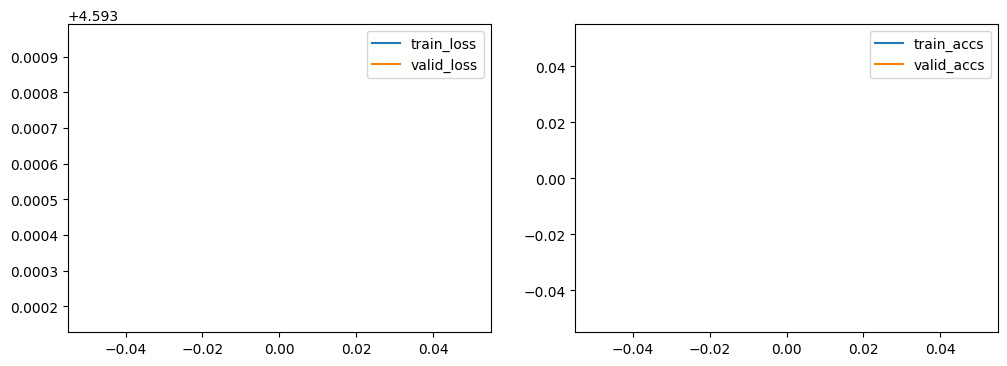

Train, it: 0 loss: 4.59 accs: 0.00
Valid, it: 0 loss: 4.59 accs: 0.00

 Step:  1
 Step:  2
 Step:  3
 Step:  4
 Step:  5
 Step:  6
 Step:  7
 Step:  8
 Step:  9
 Step:  10
 Step:  11
 Step:  12
 Step:  13
 Step:  14
 Step:  15
 Step:  16
 Step:  17
 Step:  18
 Step:  19
 Step:  20
 Step:  21
 Step:  22
 Step:  23
 Step:  24
 Step:  25
 Step:  26
 Step:  27
 Step:  28
 Step:  29
 Step:  30
 Step:  31
 Step:  32
 Step:  33
 Step:  34
 Step:  35
 Step:  36
 Step:  37
 Step:  38
 Step:  39
 Step:  40
 Step:  41
 Step:  42
 Step:  43
 Step:  44
 Step:  45
 Step:  46
 Step:  47
 Step:  48
 Step:  49
 Step:  50
 Step:  51
 Step:  52
 Step:  53
 Step:  54
 Step:  55
 Step:  56
 Step:  57
 Step:  58
 Step:  59
 Step:  60
 Step:  61
 Step:  62
 Step:  63
 Step:  64
 Step:  65
 Step:  66
 Step:  67
 Step:  68
 Step:  69
 Step:  70
 Step:  71
 Step:  72
 Step:  73
 Step:  74
 Step:  75
 Step:  76
 Step:  77
 Step:  78
 Step:  79
 Step:  80
 Step:  81
 Step:  82
 Step:  83
 Step:  84
 Step:  85
 St

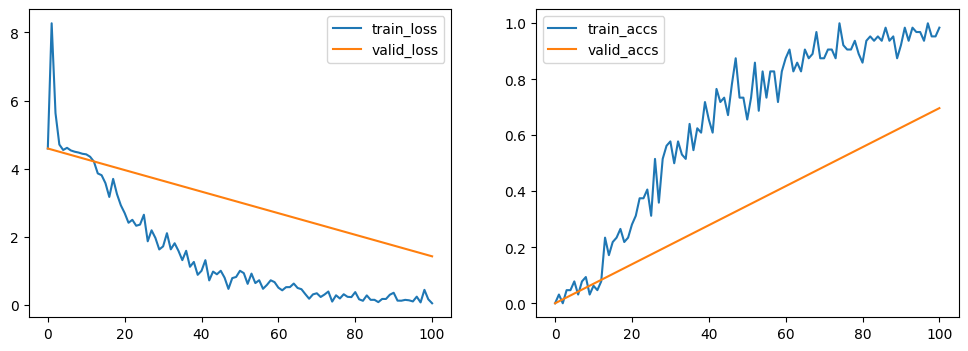

Train, it: 100 loss: 0.06 accs: 0.98
Valid, it: 100 loss: 1.43 accs: 0.70

 Step:  101
 Step:  102
 Step:  103
 Step:  104
 Step:  105
 Step:  106
 Step:  107
 Step:  108
 Step:  109
 Step:  110
 Step:  111
 Step:  112
 Step:  113
 Step:  114
 Step:  115
 Step:  116
 Step:  117
 Step:  118
 Step:  119
 Step:  120
 Step:  121
 Step:  122
 Step:  123
 Step:  124
 Step:  125
 Step:  126
 Step:  127
 Step:  128
 Step:  129
 Step:  130
 Step:  131
 Step:  132
 Step:  133
 Step:  134
 Step:  135
 Step:  136
 Step:  137
 Step:  138
 Step:  139
 Step:  140
 Step:  141
 Step:  142
 Step:  143
 Step:  144
 Step:  145
 Step:  146
 Step:  147
 Step:  148
 Step:  149
 Step:  150
 Step:  151
 Step:  152
 Step:  153
 Step:  154
 Step:  155
 Step:  156
 Step:  157
 Step:  158
 Step:  159
 Step:  160
 Step:  161
 Step:  162
 Step:  163
 Step:  164
 Step:  165
 Step:  166
 Step:  167
 Step:  168
 Step:  169
 Step:  170
 Step:  171
 Step:  172
 Step:  173
 Step:  174
 Step:  175
 Step:  176
 Step:  177
 

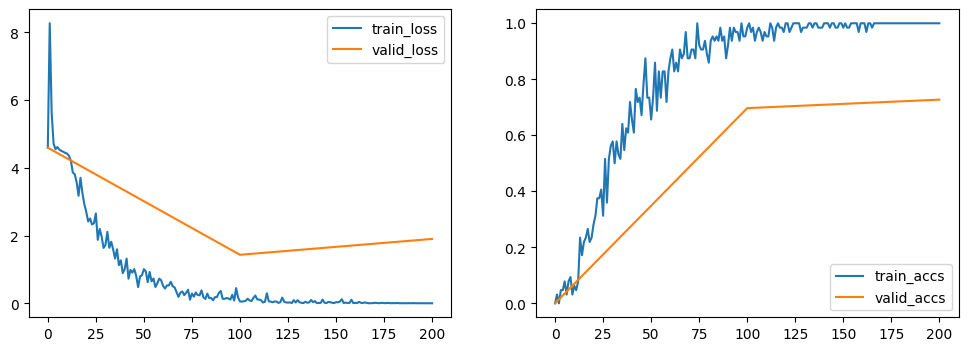

Train, it: 200 loss: 0.00 accs: 1.00
Valid, it: 200 loss: 1.90 accs: 0.73

 Step:  201
 Step:  202
 Step:  203
 Step:  204
 Step:  205
 Step:  206
 Step:  207
 Step:  208
 Step:  209
 Step:  210
 Step:  211
 Step:  212
 Step:  213
 Step:  214
 Step:  215
 Step:  216
 Step:  217
 Step:  218
 Step:  219
 Step:  220
 Step:  221
 Step:  222
 Step:  223
 Step:  224
 Step:  225
 Step:  226
 Step:  227
 Step:  228
 Step:  229
 Step:  230
 Step:  231
 Step:  232
 Step:  233
 Step:  234
 Step:  235
 Step:  236
 Step:  237
 Step:  238
 Step:  239
 Step:  240
 Step:  241
 Step:  242
 Step:  243
 Step:  244
 Step:  245
 Step:  246
 Step:  247
 Step:  248
 Step:  249
 Step:  250
 Step:  251
 Step:  252
 Step:  253
 Step:  254
 Step:  255
 Step:  256
 Step:  257
 Step:  258
 Step:  259
 Step:  260
 Step:  261
 Step:  262
 Step:  263
 Step:  264
 Step:  265
 Step:  266
 Step:  267
 Step:  268
 Step:  269
 Step:  270
 Step:  271
 Step:  272
 Step:  273
 Step:  274
 Step:  275
 Step:  276
 Step:  277
 

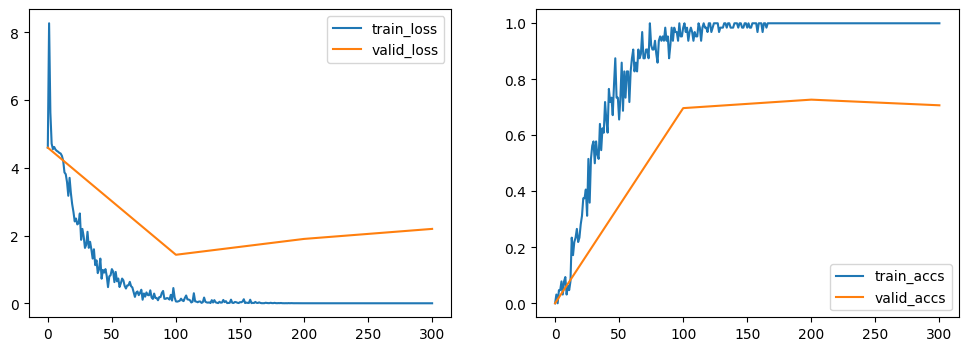

Train, it: 300 loss: 0.00 accs: 1.00
Valid, it: 300 loss: 2.20 accs: 0.71

 Step:  301
 Step:  302
 Step:  303
 Step:  304
 Step:  305
 Step:  306
 Step:  307
 Step:  308
 Step:  309
 Step:  310
 Step:  311
 Step:  312
 Step:  313
 Step:  314
 Step:  315
 Step:  316
 Step:  317
 Step:  318
 Step:  319
 Step:  320
 Step:  321
 Step:  322
 Step:  323
 Step:  324
 Step:  325
 Step:  326
 Step:  327
 Step:  328
 Step:  329
 Step:  330
 Step:  331
 Step:  332
 Step:  333
 Step:  334
 Step:  335
 Step:  336
 Step:  337
 Step:  338
 Step:  339
 Step:  340
 Step:  341
 Step:  342
 Step:  343
 Step:  344
 Step:  345
 Step:  346
 Step:  347
 Step:  348
 Step:  349
 Step:  350
 Step:  351
 Step:  352
 Step:  353
 Step:  354
 Step:  355
 Step:  356
 Step:  357
 Step:  358
 Step:  359
 Step:  360
 Step:  361
 Step:  362
 Step:  363
 Step:  364
 Step:  365
 Step:  366
 Step:  367
 Step:  368
 Step:  369
 Step:  370
 Step:  371
 Step:  372
 Step:  373
 Step:  374
 Step:  375
 Step:  376
 Step:  377
 

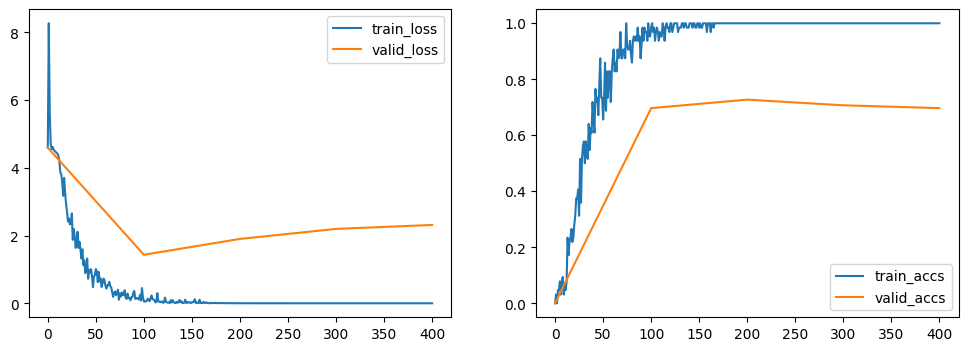

Train, it: 400 loss: 0.00 accs: 1.00
Valid, it: 400 loss: 2.31 accs: 0.70

 Step:  401
 Step:  402
 Step:  403
 Step:  404
 Step:  405
 Step:  406
 Step:  407
 Step:  408
 Step:  409
 Step:  410
 Step:  411
 Step:  412
 Step:  413
 Step:  414
 Step:  415
 Step:  416
 Step:  417
 Step:  418
 Step:  419
 Step:  420
 Step:  421
 Step:  422
 Step:  423
 Step:  424
 Step:  425
 Step:  426
 Step:  427
 Step:  428
 Step:  429
 Step:  430
 Step:  431
 Step:  432
 Step:  433
 Step:  434
 Step:  435
 Step:  436
 Step:  437
 Step:  438
 Step:  439
 Step:  440
 Step:  441
 Step:  442
 Step:  443
 Step:  444
 Step:  445
 Step:  446
 Step:  447
 Step:  448
 Step:  449
 Step:  450
 Step:  451
 Step:  452
 Step:  453
 Step:  454
 Step:  455
 Step:  456
 Step:  457
 Step:  458
 Step:  459
 Step:  460
 Step:  461
 Step:  462
 Step:  463
 Step:  464
 Step:  465
 Step:  466
 Step:  467
 Step:  468
 Step:  469
 Step:  470
 Step:  471
 Step:  472
 Step:  473
 Step:  474
 Step:  475
 Step:  476
 Step:  477
 

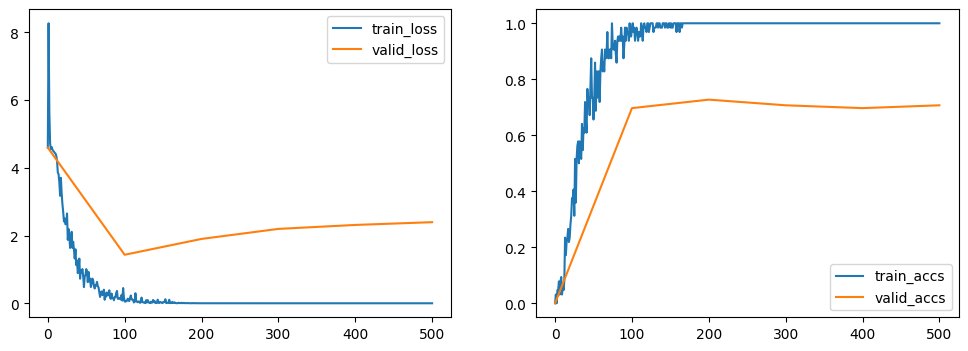

Train, it: 500 loss: 0.00 accs: 1.00
Valid, it: 500 loss: 2.39 accs: 0.71

 Step:  501
 Step:  502
 Step:  503
 Step:  504
 Step:  505
 Step:  506
 Step:  507
 Step:  508
 Step:  509
 Step:  510
 Step:  511
 Step:  512
 Step:  513
 Step:  514
 Step:  515
 Step:  516
 Step:  517
 Step:  518
 Step:  519
 Step:  520
 Step:  521
 Step:  522
 Step:  523
 Step:  524
 Step:  525
 Step:  526
 Step:  527
 Step:  528
 Step:  529
 Step:  530
 Step:  531
 Step:  532
 Step:  533
 Step:  534
 Step:  535
 Step:  536
 Step:  537
 Step:  538
 Step:  539
 Step:  540
 Step:  541
 Step:  542
 Step:  543
 Step:  544
 Step:  545
 Step:  546
 Step:  547
 Step:  548
 Step:  549
 Step:  550
 Step:  551
 Step:  552
 Step:  553
 Step:  554
 Step:  555
 Step:  556
 Step:  557
 Step:  558
 Step:  559
 Step:  560
 Step:  561
 Step:  562
 Step:  563
 Step:  564
 Step:  565
 Step:  566
 Step:  567
 Step:  568
 Step:  569
 Step:  570
 Step:  571
 Step:  572
 Step:  573
 Step:  574
 Step:  575
 Step:  576
 Step:  577
 

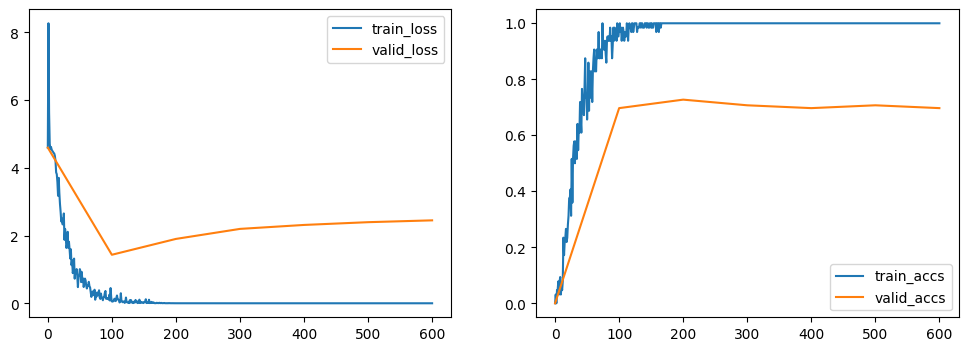

Train, it: 600 loss: 0.00 accs: 1.00
Valid, it: 600 loss: 2.45 accs: 0.70

 Step:  601
 Step:  602
 Step:  603
 Step:  604
 Step:  605
 Step:  606
 Step:  607
 Step:  608
 Step:  609
 Step:  610
 Step:  611
 Step:  612
 Step:  613
 Step:  614
 Step:  615
 Step:  616
 Step:  617
 Step:  618
 Step:  619
 Step:  620
 Step:  621
 Step:  622
 Step:  623
 Step:  624
 Step:  625
 Step:  626
 Step:  627
 Step:  628
 Step:  629
 Step:  630
 Step:  631
 Step:  632
 Step:  633
 Step:  634
 Step:  635
 Step:  636
 Step:  637
 Step:  638
 Step:  639
 Step:  640
 Step:  641
 Step:  642
 Step:  643
 Step:  644
 Step:  645
 Step:  646
 Step:  647
 Step:  648
 Step:  649
 Step:  650
 Step:  651
 Step:  652
 Step:  653
 Step:  654
 Step:  655
 Step:  656
 Step:  657
 Step:  658
 Step:  659
 Step:  660
 Step:  661
 Step:  662
 Step:  663
 Step:  664
 Step:  665
 Step:  666
 Step:  667
 Step:  668
 Step:  669
 Step:  670
 Step:  671
 Step:  672
 Step:  673
 Step:  674
 Step:  675
 Step:  676
 Step:  677
 

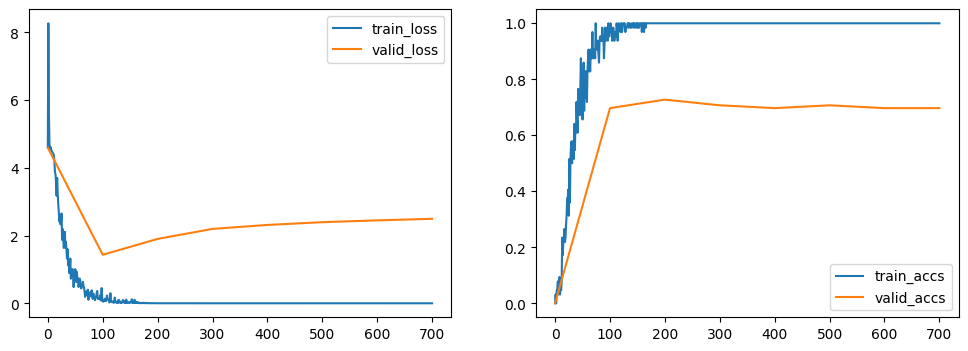

Train, it: 700 loss: 0.00 accs: 1.00
Valid, it: 700 loss: 2.49 accs: 0.70

 Step:  701
 Step:  702
 Step:  703
 Step:  704
 Step:  705
 Step:  706
 Step:  707
 Step:  708
 Step:  709
 Step:  710
 Step:  711
 Step:  712
 Step:  713
 Step:  714
 Step:  715
 Step:  716
 Step:  717
 Step:  718
 Step:  719
 Step:  720
 Step:  721
 Step:  722
 Step:  723
 Step:  724
 Step:  725
 Step:  726
 Step:  727
 Step:  728
 Step:  729
 Step:  730
 Step:  731
 Step:  732
 Step:  733
 Step:  734
 Step:  735
 Step:  736
 Step:  737
 Step:  738
 Step:  739
 Step:  740
 Step:  741
 Step:  742
 Step:  743
 Step:  744
 Step:  745
 Step:  746
 Step:  747
 Step:  748
 Step:  749
 Step:  750
 Step:  751
 Step:  752
 Step:  753
 Step:  754
 Step:  755
 Step:  756
 Step:  757
 Step:  758
 Step:  759
 Step:  760
 Step:  761
 Step:  762
 Step:  763
 Step:  764
 Step:  765
 Step:  766
 Step:  767
 Step:  768
 Step:  769
 Step:  770
 Step:  771
 Step:  772
 Step:  773
 Step:  774
 Step:  775
 Step:  776
 Step:  777
 

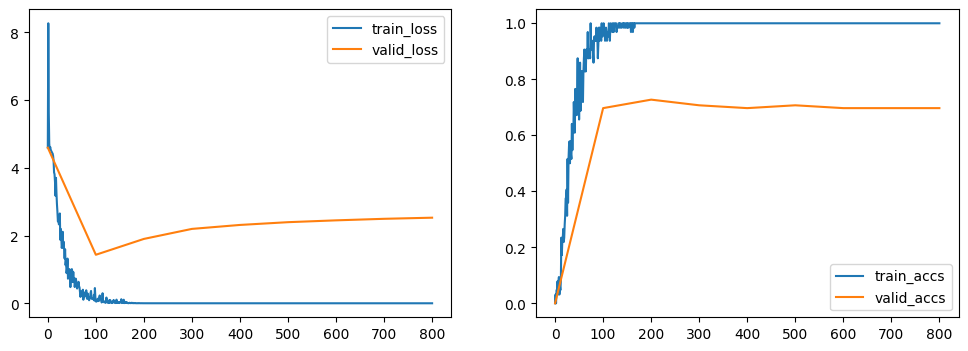

Train, it: 800 loss: 0.00 accs: 1.00
Valid, it: 800 loss: 2.53 accs: 0.70

 Step:  801
 Step:  802
 Step:  803
 Step:  804
 Step:  805
 Step:  806
 Step:  807
 Step:  808
 Step:  809
 Step:  810
 Step:  811
 Step:  812
 Step:  813
 Step:  814
 Step:  815
 Step:  816
 Step:  817
 Step:  818
 Step:  819
 Step:  820
 Step:  821
 Step:  822
 Step:  823
 Step:  824
 Step:  825
 Step:  826
 Step:  827
 Step:  828
 Step:  829
 Step:  830
 Step:  831
 Step:  832
 Step:  833
 Step:  834
 Step:  835
 Step:  836
 Step:  837
 Step:  838
 Step:  839
 Step:  840
 Step:  841
 Step:  842
 Step:  843
 Step:  844
 Step:  845
 Step:  846
 Step:  847
 Step:  848
 Step:  849
 Step:  850
 Step:  851
 Step:  852
 Step:  853
 Step:  854
 Step:  855
 Step:  856
 Step:  857
 Step:  858
 Step:  859
 Step:  860
 Step:  861
 Step:  862
 Step:  863
 Step:  864
 Step:  865
 Step:  866
 Step:  867
 Step:  868
 Step:  869
 Step:  870
 Step:  871
 Step:  872
 Step:  873
 Step:  874
 Step:  875
 Step:  876
 Step:  877
 

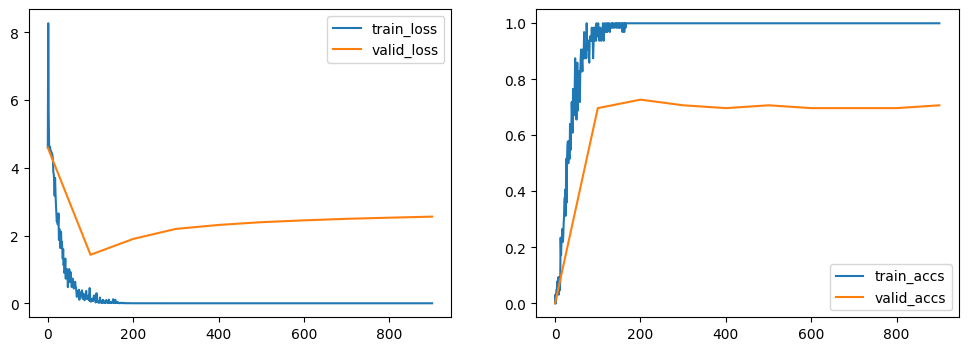

Train, it: 900 loss: 0.00 accs: 1.00
Valid, it: 900 loss: 2.56 accs: 0.71

 Step:  901
 Step:  902
 Step:  903
 Step:  904
 Step:  905
 Step:  906
 Step:  907
 Step:  908
 Step:  909
 Step:  910
 Step:  911
 Step:  912
 Step:  913
 Step:  914
 Step:  915
 Step:  916
 Step:  917
 Step:  918
 Step:  919
 Step:  920
 Step:  921
 Step:  922
 Step:  923
 Step:  924
 Step:  925
 Step:  926
 Step:  927
 Step:  928
 Step:  929
 Step:  930
 Step:  931
 Step:  932
 Step:  933
 Step:  934
 Step:  935
 Step:  936
 Step:  937
 Step:  938
 Step:  939
 Step:  940
 Step:  941
 Step:  942
 Step:  943
 Step:  944
 Step:  945
 Step:  946
 Step:  947
 Step:  948
 Step:  949
 Step:  950
 Step:  951
 Step:  952
 Step:  953
 Step:  954
 Step:  955
 Step:  956
 Step:  957
 Step:  958
 Step:  959
 Step:  960
 Step:  961
 Step:  962
 Step:  963
 Step:  964
 Step:  965
 Step:  966
 Step:  967
 Step:  968
 Step:  969
 Step:  970
 Step:  971
 Step:  972
 Step:  973
 Step:  974
 Step:  975
 Step:  976
 Step:  977
 

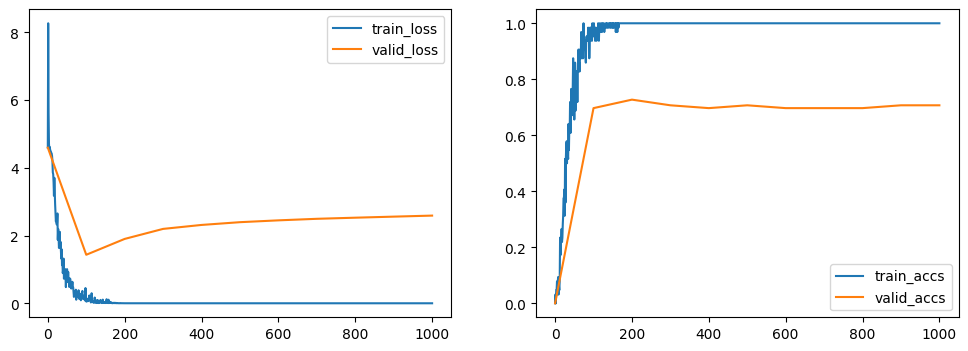

Train, it: 1000 loss: 0.00 accs: 1.00
Valid, it: 1000 loss: 2.59 accs: 0.71



In [38]:
# train the new network
train_results = train_network(net, data, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=100, eval_every=100, validation_size=0.1)

My previous network showed  clear signs of overfitting. Therefore I will proceed to implement some regularization. 

I do this by adding batch normalization 

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming the IMAGE_SHAPE is already defined
height, width, channels = IMAGE_SHAPE
conv_out_channels = 32  # Example value
kernel_size = 3         # Example value
conv_stride = 1         # Example value
conv_pad = 1            # Example value
NUM_CLASSES = 99        # Example value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Convolutional layers
        self.conv_1 = nn.Conv2d(in_channels=channels,
                                out_channels=conv_out_channels,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn1 = nn.BatchNorm2d(conv_out_channels)  # Batch normalization for conv_1
        
        self.conv_2 = nn.Conv2d(in_channels=conv_out_channels,
                                out_channels=64,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization for conv_2
        
        self.conv_3 = nn.Conv2d(in_channels=64,
                                out_channels=128,
                                kernel_size=kernel_size,
                                stride=conv_stride,
                                padding=conv_pad)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization for conv_3
        
        # Pooling layer (shared by all conv layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layer
        output_size = 128 * (height // 8) * (width // 8)  # 8 = 2 * 2 * 2 (3 pooling layers)
        self.fc = nn.Linear(in_features=output_size, out_features=256)
        self.bn_fc = nn.BatchNorm1d(256)  # Batch normalization for fully connected layer
        
        # GRU layer
        self.rnn = nn.GRU(input_size=64, hidden_size=32, batch_first=True)
        
        # Output layer
        # 256 (FC) + 64 (margin) + 64 (texture) + 32 (GRU)
        features_cat_size = 256 + 64 + 64 + 32 
        self.l_out = nn.Linear(in_features=features_cat_size, out_features=NUM_CLASSES, bias=False)
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}
        
        ## Convolutional layers with pooling and batch normalization ##
        x_img = x_img.view(-1, channels, height, width)  # Reshape to (batch_size, channels, height, width)
        x_img = self.pool(F.relu(self.bn1(self.conv_1(x_img))))    # Apply Conv1, BN, ReLU, and Pool
        x_img = self.pool(F.relu(self.bn2(self.conv_2(x_img))))    # Apply Conv2, BN, ReLU, and Pool
        x_img = self.pool(F.relu(self.bn3(self.conv_3(x_img))))    # Apply Conv3, BN, ReLU, and Pool
        
        # Flatten the output of the final convolutional layer
        features_img = x_img.view(x_img.size(0), -1)     # Flatten to (batch_size, output_size)
        features_fc = self.fc(features_img)              # Fully connected layer
        features_fc = self.bn_fc(features_fc)            # Apply batch normalization to fully connected layer
        features.append(features_fc)
        
        ## Use concatenated leaf features for FFNN ##
        x = torch.cat((x_margin, x_texture), dim=1)  # Concatenate margin and texture features
        features.append(x)
        
        ## Use concatenated leaf features for RNN ##
        x_shape = x_shape.unsqueeze(1)               # Add sequence dimension for GRU (batch_size, seq_len=1, input_size=64)
        rnn_out, _ = self.rnn(x_shape)               # Apply GRU
        features_rnn = rnn_out[:, -1, :]             # Take the last time step output
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        features_final = torch.cat(features, dim=1)  # Concatenate all features
        out['out'] = self.l_out(features_final)      # Pass through the final linear layer
        
        return out


In [59]:
# init the new network
net = initialize_network()


Using GPU


In [60]:
# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [61]:
# train the new network
train_results = train_network(net, data, criterion, optimizer, batch_size, NUM_CLASSES, max_iter=1000, log_every=100, eval_every=100, validation_size=0.1)

 Step:  0
Evaluating


KeyboardInterrupt: 

# Submission to Kaggle

First we have to make test set predictions, then we have to place the output in the submission file and then upload to Kaggle to get our score! You can upload up to 5 submissions per day.

In [56]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test, preds_test = [], []
net.eval()
# run like with validation
for batch_test, num in batch_gen.gen_test():
    output = net(**get_input(batch_test))
    y_out = output['out'].data

    ids_test += batch_test['ids']
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

NameError: name 'batch_gen' is not defined

## Make submission file

In [ ]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv(drive_path + 'submission.csv', index=False)

# below prints the submission, can be removed and replaced with code block below
submission.head(5)

## Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/submit`](https://www.kaggle.com/c/leaf-classification/submit)
3. Click or drop your submission here (writing a description is good practice)
4. Submit and look at where you are on the leaderboard.

Success! 